In [3]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.7/252.7 MB 5.5 MB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 6.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 5.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 6.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.4/670.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 6.2 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [5]:
pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 3.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 25.0
    Uninstalling pip-25.0:
      Successfully uninstalled pip-25.0
Note: you may need to restart the kernel to use updated packages.


In [1]:
# File: /notebooks/predict_anomalies.ipynb

"""
This notebook simulates sensor data from a mining environment and uses an Isolation Forest model
and LSTM model to detect anomalies and forecast future values. It serves as a prototype for the
AI-based predictive monitoring system for underground mines.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

/var/folders/pr/vf_08d957yz8y2x6y3v19r6c0000gn/T/ipykernel_6847/3399492883.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range("2024-01-01", periods=n, freq="H")


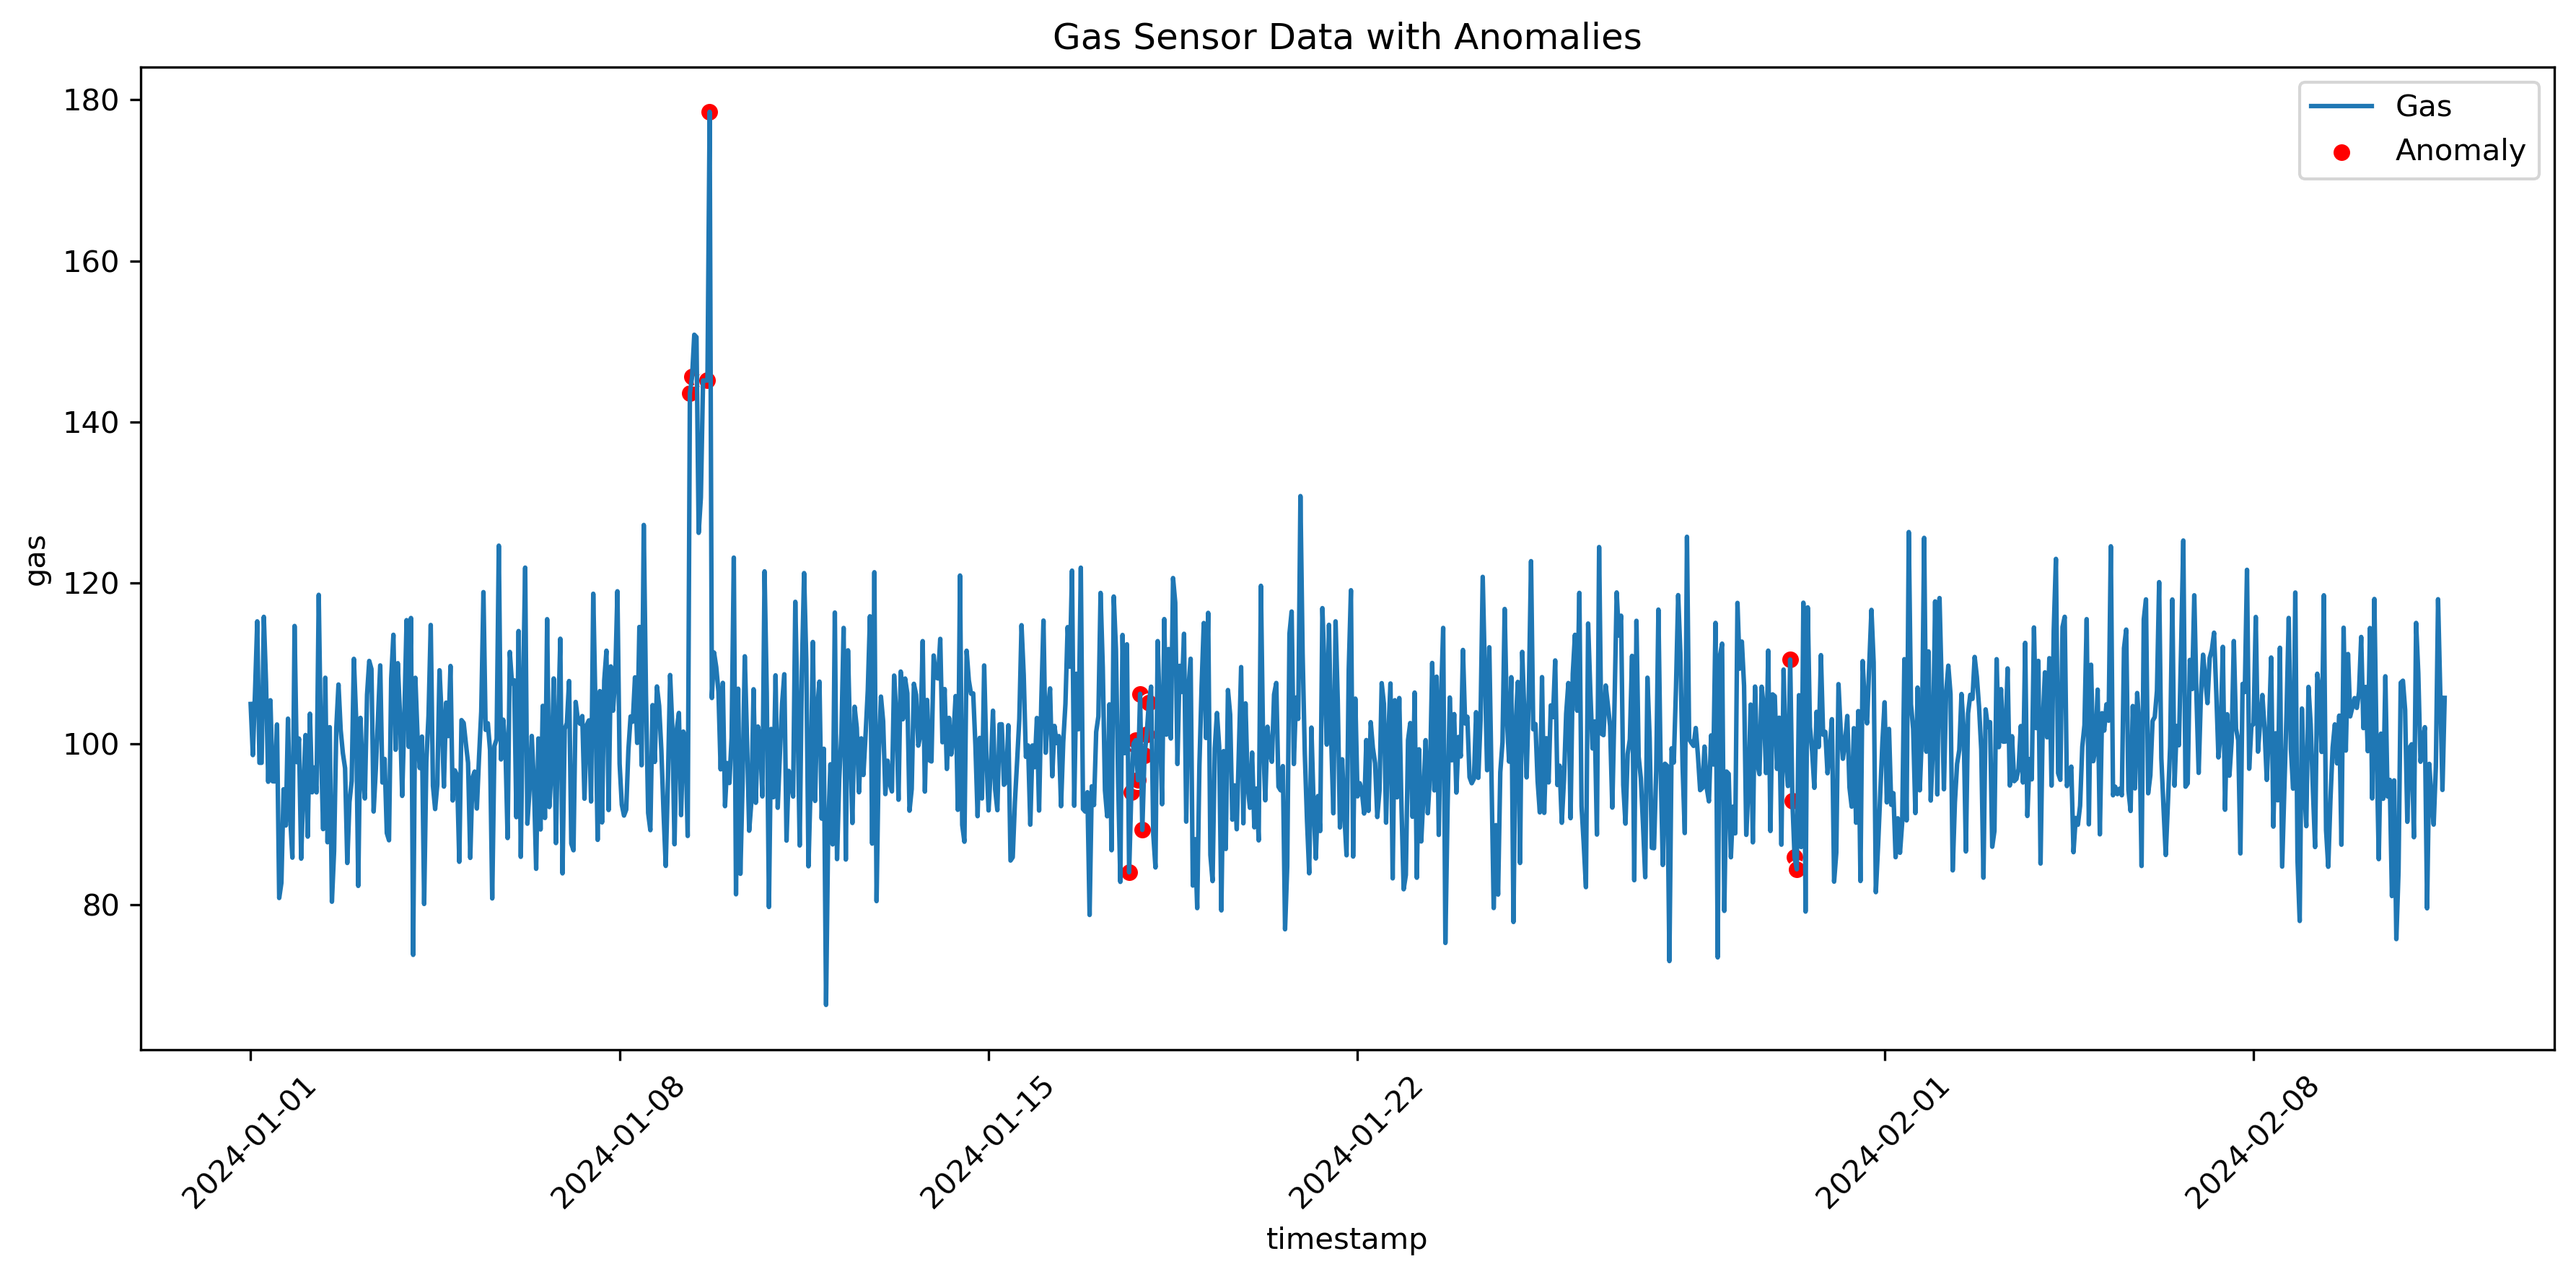

In [7]:
# Simulate time-series sensor data
np.random.seed(42)
n = 1000
timestamps = pd.date_range("2024-01-01", periods=n, freq="H")
gas = np.random.normal(100, 10, n)
temperature = np.random.normal(35, 2.5, n)
vibration = np.random.normal(0.25, 0.05, n)

# Inject anomalies
gas[200:210] += 40
temperature[700:705] += 10
vibration[400:410] += 0.4

# Create dataframe
data = pd.DataFrame({
    "timestamp": timestamps,
    "gas": gas,
    "temperature": temperature,
    "vibration": vibration
})

# --- Isolation Forest Anomaly Detection ---
X = data[["gas", "temperature", "vibration"]]
iso_forest = IsolationForest(contamination=0.02, random_state=42)
data["anomaly_score"] = iso_forest.fit_predict(X)
data["anomaly"] = data["anomaly_score"] == -1

# --- Visualization ---
plt.figure(figsize=(12, 6), dpi=300)
sns.lineplot(x="timestamp", y="gas", data=data, label="Gas")
sns.scatterplot(x="timestamp", y="gas", data=data[data.anomaly], color='red', label="Anomaly")
plt.xticks(rotation=45)
plt.title("Gas Sensor Data with Anomalies")
plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/var/folders/pr/vf_08d957yz8y2x6y3v19r6c0000gn/T/ipykernel_6847/3198556878.py:41: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plt.plot(pd.date_range(data['timestamp'].iloc[-1], periods=51, freq="H")[1:], forecast, label="Forecast", color='orange')


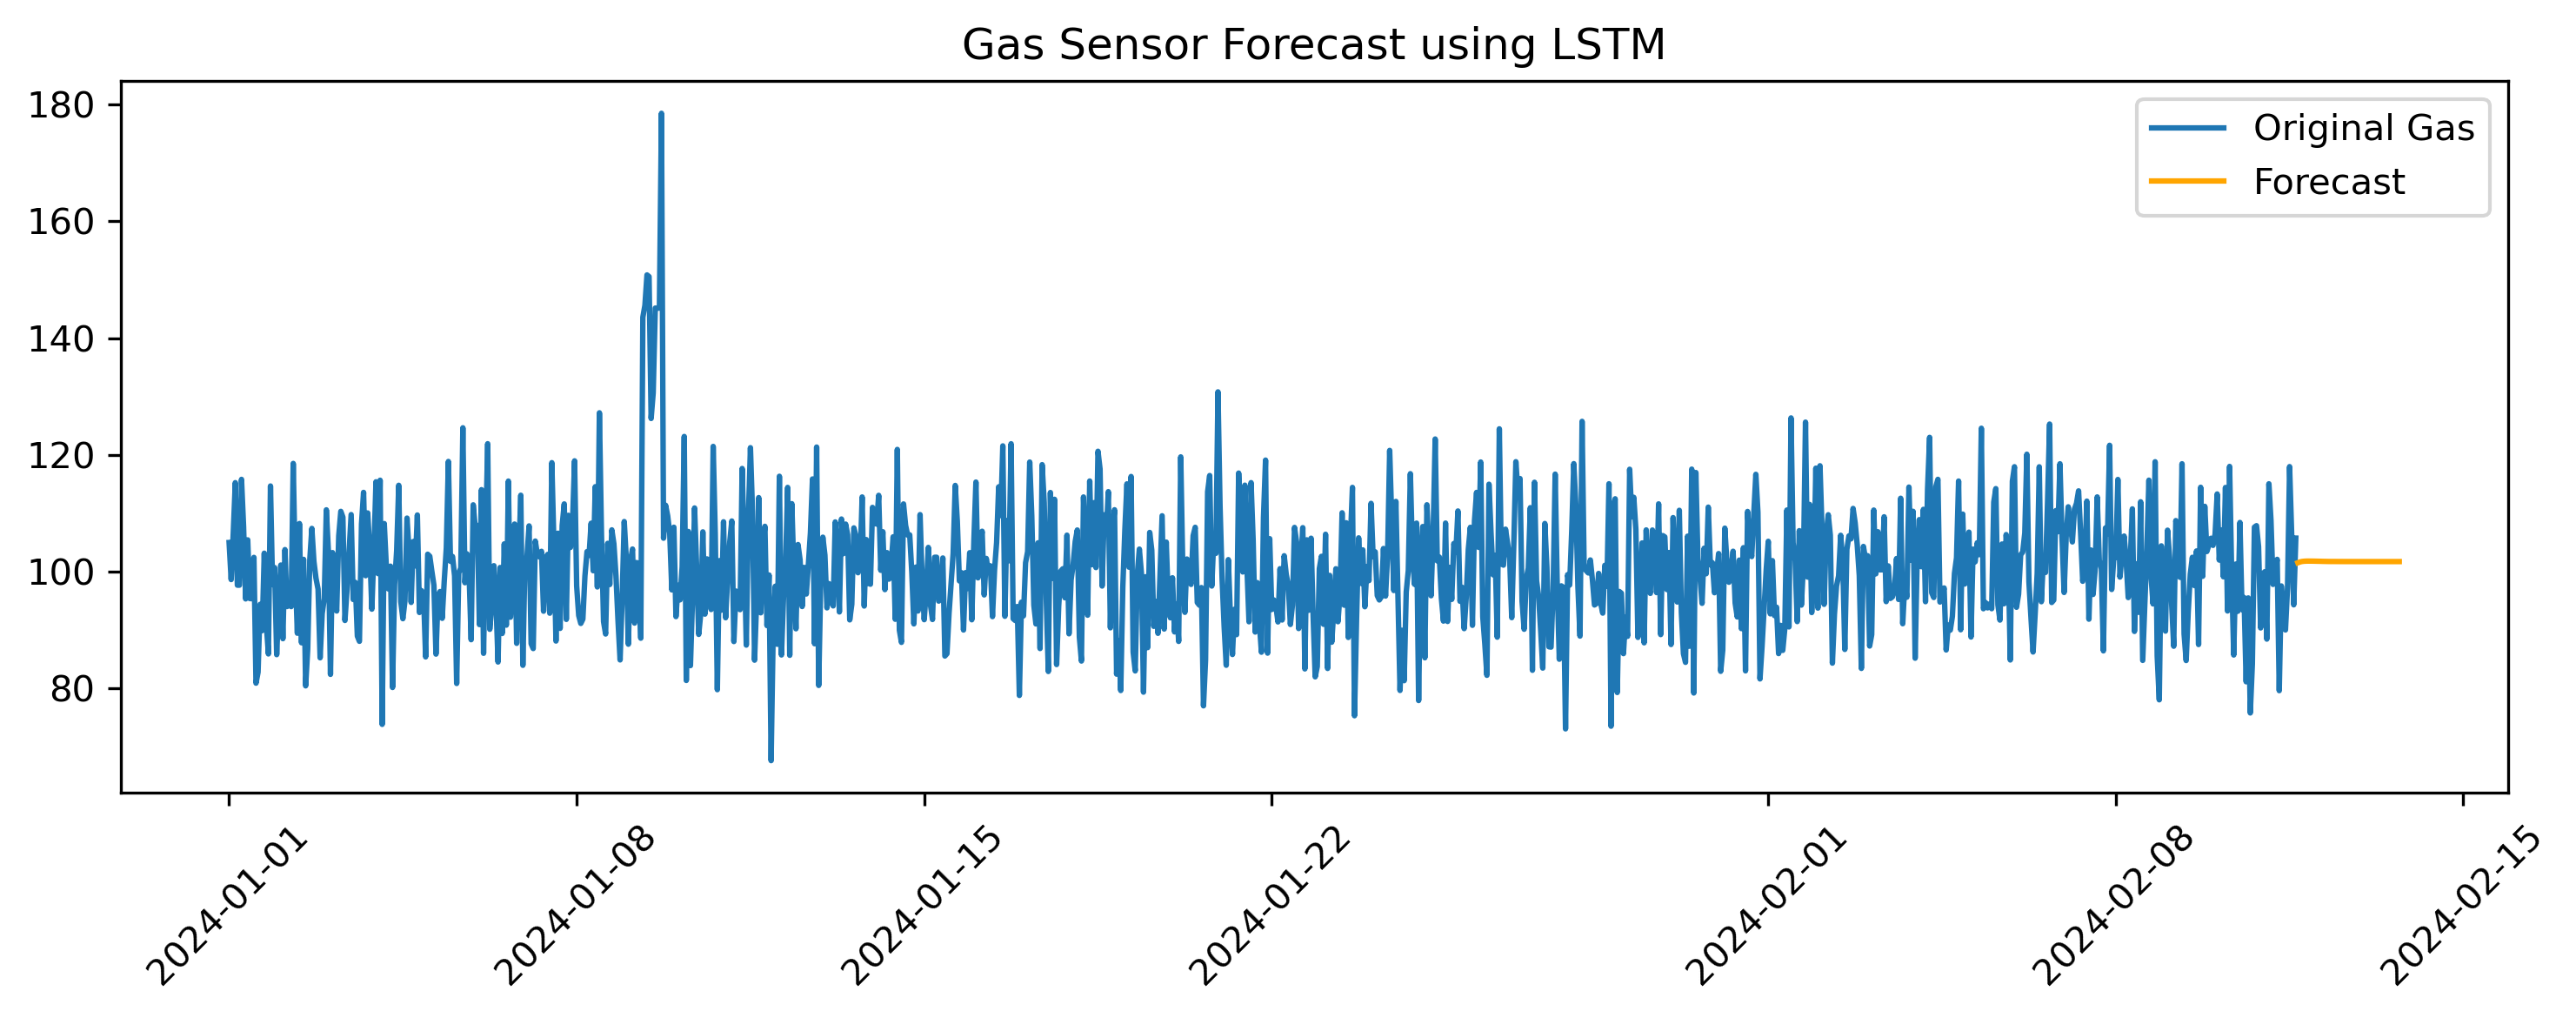

In [9]:
# --- LSTM Forecasting ---
scaler = MinMaxScaler()
scaled_gas = scaler.fit_transform(data[["gas"]])

# Prepare sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_len = 20
X_seq, y_seq = create_sequences(scaled_gas, seq_len)
X_seq = X_seq.reshape((X_seq.shape[0], X_seq.shape[1], 1))

# Build LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_seq.shape[1], 1), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_seq, y_seq, epochs=10, batch_size=16, verbose=0)

# Forecast next 50 values
last_seq = scaled_gas[-seq_len:]
forecast = []
input_seq = last_seq.reshape((1, seq_len, 1))
for _ in range(50):
    next_val = model.predict(input_seq, verbose=0)[0][0]
    forecast.append(next_val)
    input_seq = np.append(input_seq[:, 1:, :], [[[next_val]]], axis=1)

forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Plot forecast
plt.figure(figsize=(10, 4), dpi=300)
plt.plot(data['timestamp'], data['gas'], label="Original Gas")
plt.plot(pd.date_range(data['timestamp'].iloc[-1], periods=51, freq="H")[1:], forecast, label="Forecast", color='orange')
plt.legend()
plt.title("Gas Sensor Forecast using LSTM")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
